# Install

In [1]:
import os
os.chdir('./GymGo-master')

In [2]:
import gym
import random
import pandas as pd
import numpy as np
from sklearn import preprocessing
import math
from gym_go import state_utils, govars

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import iqr
import pickle
import time

# env

In [3]:
# 8 same symmetries
def all_symmetries(image):
    """
    :param image: A (C, BOARD_SIZE, BOARD_SIZE) numpy array, where C is any number
    :return: All 8 orientations that are symmetrical in a Go game over the 2nd and 3rd axes
    (i.e. rotations, flipping and combos of them)
    """
    symmetries = []

    for i in range(8):
        x = image
        if (i >> 0) % 2:
            # Horizontal flip
            x = np.flip(x, 2)
        if (i >> 1) % 2:
            # Vertical flip
            x = np.flip(x, 1)
        if (i >> 2) % 2:
            # Rotation 90 degrees
            x = np.rot90(x, axes=(1, 2))
            
        symmetries.append(x)

    return symmetries
#all_symmetries(state1)

In [4]:
# one state to num
def state2num(state1,size):
    # state1 is a size*size*6 matrix
    
    
    state1 = state1.astype(int)
    state = state1[0:2].reshape(size**2*2)
    num = int("".join(str(x) for x in state), 2)
    
    return num

# all states to num
def all_state2num(state1, size):
    # state1 is a size*size*6 matrix
    state1 = state1.astype(int)
    all_b = all_symmetries(state1[0].reshape(1,size,size))
    all_w = all_symmetries(state1[1].reshape(1,size,size))
    ls = []
    for i in range(8):
        state = np.concatenate((all_b[i].reshape(size**2),all_w[i].reshape(size**2)), axis=None)
        num = int("".join(str(x) for x in state), 2)
        ls.append(num)
    return ls

#state2num(state1, size), all_state2num(state1, size)

In [5]:

def symmetry_action(ls, l, action, size):
    # ls is all symmetry fucntion
    # l is all keys in value function
    # action is an int
    
    # return rotated action and flag indicating if the state exists
    flag = False
    state = ls[0]
    for i in range(len(ls)):
        if ls[i] in l:
            flag = True
            if action == size**2:
                state = ls[i]
                break
            
            a = math.floor(action/size)
            b = action%size
            s = size - 1
            if i == 1:
                b = s-b
            elif i == 2:
                a = s-a
            elif i == 3:
                a = s-a
                b = s-b
            elif i == 4:
                b = a
                a = b
            elif i == 5:
                a = s-b
                b = a
            elif i == 6:
                a = b
                b = s-a
            elif i == 7:
                a = s-b
                b = s-a
            action = size * a + b
            state = ls[i]
            break
    return action, state, flag


In [6]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [7]:
def invalid_moves(state):
    # return a fixed size binary vector
    if game_ended(state):
        return np.zeros(action_size(state))
    return np.append(state[govars.INVD_CHNL].flatten(), 0)


def valid_moves(state):
    return 1 - invalid_moves(state)

In [18]:
# Program
class Learn(object):

    # board size, value function, action function
    def __init__(self, size):
        self.size = size
        # define state value function as a dict
        # key is position of b and w
        # value is state value (a number)
        self.value_function = dict()
        
        # add new state if not exist
        #if tuple(go_env.state()[0:2].reshape(size**2*2)) not in value_function: 
        #    value_function[tuple(go_env.state()[0:2].reshape(size**2*2))] = 0
        
        # define action value function as a dict
        # key is position of b and w
        # value is action value (an array)
        self.action_function = dict()
        
        
        #if tuple(go_env.state()[0:2].reshape(size**2*2)) not in action_function:
        #    action_function[tuple(go_env.state()[0:2].reshape(size**2*2))] = np.zeros(size**2+1)
        
        self.env = gym.make('gym_go:go-v0', size=self.size, reward_method = "real")
        self.env.reset()
        
        #self.state = self.env.state()[0:2].reshape(size**2*2)
    
    # helper
    #def intersection(self, lst1, lst2):
    #    lst3 = [value for value in lst1 if value in lst2]
    #    return lst3
    
    ## load policy
    def load_policy(self, dictionary):
        self.action_function = dictionary
        
        

    ## greedy policy
    def apply_policy(self, states, epsilon):
        """
        Apply the policy of the agent
        Args:
            state: tuple of length 2
            epsilon: exploration probability, 0 for greedy behavior, 1 for pure exploration
        Returns:
            the selected action for the state under the current policy
        """
        ## random
        if np.random.uniform(0, 1) < epsilon:
            action_index = self.env.uniform_random_action()
        else: 
            # if not in action function, build a new one
            
            [x, state, flag] = symmetry_action(states, self.action_function, 0, self.size)
            if not flag:
                action_index = self.env.uniform_random_action()
                #self.action_function[state] = np.zeros(self.size**2+1)
            #if state not in self.action_function:
            #    self.action_function[state] = np.zeros(self.size**2+1)
            
            else:
                # actions with max value
                greedy_action_value = np.max(self.action_function[state])
                greedy_indices = [i for i, a in enumerate(self.action_function[state]) if
                              a == greedy_action_value]

                valid = np.nonzero(self.env.valid_moves())[0]

                # overlap between max and valid action 
                #idx = intersection(greedy_indices, valid)
                #if idx == []:
                #    action_idx = self.size**2
                #print(greedy_indices)
                #else:
                #    action_idx = np.random.choice(intersection(greedy_indices, valid))
                action_idx = np.random.choice(greedy_indices)
                [action_index, x, x] = symmetry_action(states, self.action_function, action_idx, self.size)
                if action_index not in valid:
                    action_index = self.env.uniform_random_action()
        
        
        return action_index
    
    def sarsa_td(self, n_episodes=1000, alpha=0.01, gamma=0.9):
        """
        Run the sarsa control algorithm (TD0), finding the optimal policy and action function
        :param n_episodes: int, amount of episodes to train
        :param alpha: learning rate
        :param gamma: discount factor of future rewards
        :return: finds the optimal policy for move chess
        """
        error = 0
        i = 0
        td_errors = []
        for k in range(n_episodes):
            self.env= gym.make('gym_go:go-v0', size=self.size, reward_method = "heuristic")
            self.env.reset()
            done = False
            epsilon = max(1 / (1 + k), 0.05)
            
            while not done:
                i += 1
                # current state - action idx
                #state = self.env.state()[0:2].reshape(self.size**2*2)
                # state = state2num(self.env.state(), self.size)
            
                states = all_state2num(self.env.state(),self.size)
                action_index = self.apply_policy(states, epsilon)
                
                
                # current state - action value
                ## check all rotations
                [action_idx, state, flag] = symmetry_action(states, self.action_function, action_index, self.size)
                #print(action_idx, action_index)
                if not flag:
                    self.action_function[state] = np.zeros(self.size**2+1)
                #print(states,action_idx)
                action_value = self.action_function[state][action_idx]
                
                
                # step
                successor_state, reward, done, info = self.env.step(action_index)
                
                
                # successor state - action idx
                #successor_state = successor_state1[0:2].reshape(self.size**2*2)
                #successor_state = state2num(successor_state1, self.size)
                successor_states = all_state2num(successor_state, self.size)
                successor_action_index = self.apply_policy(successor_states, epsilon)
                
                
                
                # successor state - action value
                ## check all rotations
                [successor_action_idx, successor_state, flag2] = symmetry_action(successor_states, 
                                                                                 self.action_function, 
                                                                                 successor_action_index,
                                                                                self.size)
                #print(successor_action_idx, successor_action_index)
                if not flag2:
                    self.action_function[successor_state] = np.zeros(self.size**2+1)
                    
                successor_action_value = self.action_function[successor_state][successor_action_idx]
                
                # update action value function
                q_update = alpha * (reward + gamma * successor_action_value - action_value)
                self.action_function[state][action_idx] += q_update
                
                error += q_update
                td_errors.append(q_update)
                if done:
                    break
                
                # white
                action = self.env.uniform_random_action()
                state, reward, done, info = self.env.step(action)
            
            if k in x:
                
                td_error = error/i
                print(td_error)
        return(td_errors)
                
        
                
                
                
                
        

In [19]:
x = list(np.linspace(0, 1000, 11)) + list(np.linspace(2000, 10000, 9))+list(np.linspace(20000, 50000, 4))


In [21]:
td = Learn(size = 3)
td_errors = td.sarsa_td(n_episodes=1000)

0.05222222222222222
0.021145531494427133
0.02142989544737446
0.021727313171495764
0.020999071942004337
0.02179369474781939
0.02173781882578605
0.021179545695726023
0.021187065063084085
0.021458682944670678


(array([4.000e+00, 1.910e+02, 3.300e+01, 1.600e+01, 1.400e+01, 1.400e+01,
        1.300e+01, 6.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        5.000e+00, 1.050e+02, 3.300e+01, 1.200e+01, 6.000e+00, 7.900e+01,
        1.100e+01, 2.000e+00, 8.000e+00, 1.650e+02, 1.400e+01, 3.000e+00,
        4.000e+00, 1.380e+02, 2.000e+00, 1.000e+00, 1.000e+00, 1.700e+02,
        1.800e+01, 2.000e+00, 0.000e+00, 2.000e+02, 1.500e+01, 8.000e+00,
        2.000e+00, 3.480e+02, 1.120e+02, 2.180e+02, 3.150e+02, 1.387e+03,
        2.750e+02, 8.600e+01, 6.500e+01, 4.340e+02, 6.200e+01, 4.000e+01,
        5.600e+01, 2.650e+02, 6.000e+01, 3.100e+01, 2.600e+01, 2.290e+02,
        5.400e+01, 2.700e+01, 1.400e+01, 1.450e+02, 4.100e+01, 2.200e+01,
        5.600e+01, 1.980e+02, 3.300e+01, 2.500e+01, 1.500e+01, 1.500e+01,
        2.100e+01, 1.500e+01, 1.200e+01, 2.300e+01, 6.300e+01, 8.100e+01,
        1.710e+02, 8.070e+02, 1.360e+02, 1.600e+01, 1.000e+01, 1.200e+01,
        5.000e+00, 6.000e+00, 4.000e+0

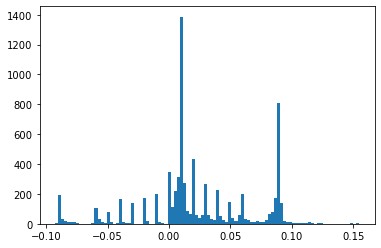

In [22]:
plt.hist(td_errors, bins = 100)

In [15]:
plt.hist(start_values[1], weights=np.ones(len(start_values[1])) / len(start_values[1]), bins = 100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('Value Function-Start')
plt.show()

NameError: name 'td_errors' is not defined

# Training

In [17]:
size = 3
ra_trials = 1000
train_episodes = [100, 1000, 10000, 50000, 100000, 150000]
eval_episodes = 1000
trial = 25

# baseline

In [ ]:
# number of episodes
rewards_non = [0]*trial
for j in range(trial):
    reward_non = 0
    for i in range(eval_episodes): 
        non = Learn(size = size)
        non.env.reset()
        done = False
        while not done:
            action = non.env.uniform_random_action()

            state, reward, done, info = non.env.step(action)
            #print(reward)
        if reward == 1:
            reward_non += 1
    rewards_non[j] = reward_non


In [34]:
reward_non = []
for i in range(1000): 
        non = Learn(size = size)
        non.env.reset()
        done = False
        while not done:
            action = non.env.uniform_random_action()

            state, reward, done, info = non.env.step(action)
            #print(reward)
        reward_non.append(reward)

# TD 
Eposodes

In [35]:
np.save("non.npy", reward_non)

In [32]:
# TD training
# number of iteration = 25
# train_episodes = [100, 1000, 10000, 100000]
# eval_episodes = 1000
start_time = time.time()
rewards_td = []

td = Learn(size = size)
for j in range(10):
        
        td.sarsa_td(n_episodes=10000)

        reward_td = []
        for i in range(1000): 
                td_eval = Learn(size = size)
                td_eval.action_function = td.action_function
                td_eval.env = gym.make('gym_go:go-v0', size=size,  reward_method = "real")
                td_eval.env.reset()
                
                done = False

                while not done:
                    states = all_state2num(td_eval.env.state(),size)
                    action_index = td_eval.apply_policy(states, 0.1)
                    state, reward, done, info = td_eval.env.step(action_index)

                    if done:
                        break
                    # white    
                    action = td_eval.env.uniform_random_action()
                    state, reward, done, info = td_eval.env.step(action)

                #print(reward)
                reward_td.append(reward)
        rewards_td.append(reward_td)
        print(j)
        #print(reward_td)


        

        
print("--- %s seconds ---" % (time.time() - start_time))



0
1
2
3
4
5
6
7
8
9
--- 1824.4945890903473 seconds ---


In [33]:
np.save("10000.npy", rewards_td)

In [ ]:
# TD training
# number of iteration = 25
# train_episodes = [100, 1000, 10000, 100000]
# eval_episodes = 1000
start_time = time.time()
rewards_td1 = []

td = Learn(size = size)
for j in range(10):
        
        td.sarsa_td(n_episodes=1000)

        reward_td = []
        for i in range(1000): 
                td_eval = Learn(size = size)
                td_eval.action_function = td.action_function
                td_eval.env = gym.make('gym_go:go-v0', size=size,  reward_method = "real")
                td_eval.env.reset()
                
                done = False

                while not done:
                    states = all_state2num(td_eval.env.state(),size)
                    action_index = td_eval.apply_policy(states, 0.1)
                    state, reward, done, info = td_eval.env.step(action_index)

                    if done:
                        break
                    # white    
                    action = td_eval.env.uniform_random_action()
                    state, reward, done, info = td_eval.env.step(action)

                #print(reward)
                reward_td.append(reward)
        rewards_td1.append(reward_td)
        print(j)
        #print(reward_td)


        

        
print("--- %s seconds ---" % (time.time() - start_time))



Hyperparameter


In [12]:
# TD training
# number of iteration = 25
# train_episodes = [100, 1000, 10000, 100000]
# eval_episodes = 1000
start_time = time.time()
rewards_td = dict()
result = np.zeros((10,10))
for j in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    for k in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        
        td = Learn(size = size)
        td.sarsa_td(n_episodes=10000, alpha=k, gamma=j)

        reward_td = 0
        for i in range(eval_episodes): 
                td.env = gym.make('gym_go:go-v0', size=size,  reward_method = "real")
                td.env.reset()
                done = False

                while not done:
                    states = all_state2num(td.env.state(),size)
                    action_index = td.apply_policy(states, 0.1)
                    state, reward, done, info = td.env.step(action_index)



                    if done:
                        break
                    # white    
                    action = td.env.uniform_random_action()
                    state, reward, done, info = td.env.step(action)

                #print(reward)
                if reward == 1:
                    reward_td = reward_td + 1
        rewards_td[j,k] = reward_td
        print(reward_td)


        

        
print("--- %s seconds ---" % (time.time() - start_time))


732
787
782
800
759
883
805
779
779
766
769
776
795
767
790
795
833
789
775
704
800
797
758
813
823
794
736
823
678
699
811
741
743
747
803
825
808
736
761
760
815
787
815
816
758
731
732
758
761
732
722
750
731
753
780
766
741
752
768
757
779
736
791
758
764
748
760
757
675
736
713
780
806
755
764
735
737
722
720
773
742
741
739
762
792
759
797
693
796
734
793
696
660
586
700
684
668
633
700
670
--- 17951.530526399612 seconds ---


In [13]:
result = np.array([732,
787,
782,
800,
759,
883,
805,
779,
779,
766,
769,
776,
795,
767,
790,
795,
833,
789,
775,
704,
800,
797,
758,
813,
823,
794,
736,
823,
678,
699,
811,
741,
743,
747,
803,
825,
808,
736,
761,
760,
815,
787,
815,
816,
758,
731,
732,
758,
761,
732,
722,
750,
731,
753,
780,
766,
741,
752,
768,
757,
779,
736,
791,
758,
764,
748,
760,
757,
675,
736,
713,
780,
806,
755,
764,
735,
737,
722,
720,
773,
742,
741,
739,
762,
792,
759,
797,
693,
796,
734,
793,
696,
660,
586,
700,
684,
668,
633,
700,
670])

In [14]:
result1 = result.reshape([10,10])
result1

array([[732, 787, 782, 800, 759, 883, 805, 779, 779, 766],
       [769, 776, 795, 767, 790, 795, 833, 789, 775, 704],
       [800, 797, 758, 813, 823, 794, 736, 823, 678, 699],
       [811, 741, 743, 747, 803, 825, 808, 736, 761, 760],
       [815, 787, 815, 816, 758, 731, 732, 758, 761, 732],
       [722, 750, 731, 753, 780, 766, 741, 752, 768, 757],
       [779, 736, 791, 758, 764, 748, 760, 757, 675, 736],
       [713, 780, 806, 755, 764, 735, 737, 722, 720, 773],
       [742, 741, 739, 762, 792, 759, 797, 693, 796, 734],
       [793, 696, 660, 586, 700, 684, 668, 633, 700, 670]])

In [18]:
np.argpartition(result, -5)[-5:]

array([24, 27, 35, 16,  5])

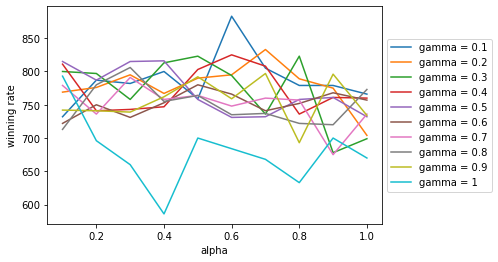

In [47]:
import matplotlib.pyplot as plt

  
# create data
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
fig = plt.figure()
ax = plt.subplot(111)  

for i in range(10):
    ax.plot(x, result1[i], label = "gamma = "+ str(x[i]))
  
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('alpha')
plt.ylabel('winning rate')
plt.show()

In [31]:
 combo = np.array([0.1, 0.6, 
    0.2, 0.7, 
    0.3, 0.5, 
    0.3, 0.8, 
    0.4, 0.6])
combo = combo.reshape(5,2)
#combo[i][0], combo[i][1]

for i in range(5):
    print(combo[i])

[0.1 0.6]
[0.2 0.7]
[0.3 0.5]
[0.3 0.8]
[0.4 0.6]


In [48]:
start_time = time.time()
rewards_td__ = np.zeros((5,25))
for k in range(5):
    for j in range(25):
        td = Learn(size = size)
        td.sarsa_td(n_episodes=10000, alpha = combo[k][1], gamma = combo[k][0])

        reward_td = 0
        for i in range(eval_episodes): 
                td.env = gym.make('gym_go:go-v0', size=size,  reward_method = "real")
                td.env.reset()
                done = False

                while not done:
                    states = all_state2num(td.env.state(),size)
                    action_index = td.apply_policy(states, 0.1)
                    state, reward, done, info = td.env.step(action_index)



                    if done:
                        break
                    # white    
                    action = td.env.uniform_random_action()
                    state, reward, done, info = td.env.step(action)

                #print(reward)
                if reward == 1:
                    reward_td = reward_td + 1
        rewards_td__[k,j] = reward_td
        print(reward_td)

        
print("--- %s seconds ---" % (time.time() - start_time))

789
766
794
783
844
803
749
736
753
735
769
722
793
718
860
711
805
849
810
756
758
774
817
822
789
709
708
761
846
740
725
820
777
790
763
755
741
784
798
788
776
809
790
780
811
809
728
770
799
746
758
784
763
787
719
754
803
770
789
790
795
825
773
751
782
807
793
788
753
705
782
799
758
806
781
710
805
761
791
792
804
839
780
777
789
750
713
774
818
734
779
687
789
721
698
803
757
762
799
745
771
774
774
796
747
763
762
805
784
804
744
720
768
817
750
737
826
808
790
747
773
749
776
845
715
--- 59744.274445056915 seconds ---


In [ ]:
plt.boxplot([rewards_td__[0], rewards_td__[1], rewards_td__[2], rewards_td__[3],rewards_td__[3]],labels=[0,100,1000,10000])
plt.xlabel('Number of Episodes')
plt.ylabel('Winning Rate')

In [ ]:
# expected short fall
import scipy
def es(array):
    array = np.asarray(array)
    value_at_risk = scipy.stats.scoreatpercentile(array, 100 * 0.05)
    cvar = array[array <= value_at_risk].mean()
    return cvar
y1 = [iqr(iteration[0]), iqr(iteration[100]),iqr(iteration[1000]),iqr(iteration[10000])]
y2 = [es(iteration[0]), es(iteration[100]),es(iteration[1000]),es(iteration[10000])]

In [24]:
sum(rewards_td__.values()), sum(x1)

(15693, 15505)

In [28]:
import statistics
statistics.stdev(rewards_td__.values()), statistics.stdev(x1)

(68.06401398683448, 51.28108813198097)

# Evaluation

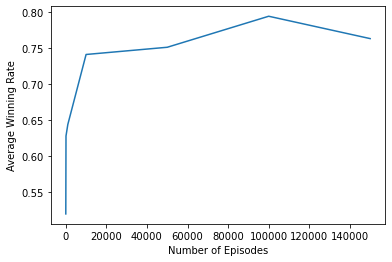

In [48]:
# winning rate plot

rate = {0:520, 100: 628, 1000: 644, 10000: 741, 50000: 751, 100000: 794, 150000: 763}

import matplotlib.pylab as plt


myList = rate.items()
myList = sorted(myList) 
x, y = zip(*myList) 

plt.plot(x, np.asarray(y)/1000)
plt.xlabel('Number of Episodes')
plt.ylabel('Average Winning Rate')
plt.show()


In [39]:
iteration = dict()
iteration[0] = np.asarray(rewards_non)/1000

x1 = [732,
576,
553,
734,
650,
610,
640,
599,
565,
685,
622,
642,
610,
635,
587,
582,
579,
589,
594,
531,
665,
592,
660,
601,
672]
iteration[100] = np.asarray(x1)/1000

x2 = {0: 669,
 1: 707,
 2: 727,
 3: 707,
 4: 663,
 5: 735,
 6: 632,
 7: 762,
 8: 778,
 9: 718,
 10: 725,
 11: 772,
 12: 690,
 13: 707,
 14: 710,
 15: 824,
 16: 639,
 17: 700,
 18: 742,
 19: 692,
 20: 713,
 21: 777,
 22: 708,
 23: 703,
 24: 714}
iteration[1000] = np.asarray(list(x2.values()))/1000

x3= {0: 743,
 1: 743,
 2: 747,
 3: 771,
 4: 775,
 5: 732,
 6: 749,
 7: 791,
 8: 824,
 9: 725,
 10: 748,
 11: 706,
 12: 754,
 13: 823,
 14: 702,
 15: 751,
 16: 823,
 17: 756,
 18: 727,
 19: 782,
 20: 672,
 21: 792,
 22: 740,
 23: 722,
 24: 749}
iteration[10000] = np.asarray(list(x3.values()))/1000

Text(0, 0.5, 'Winning Rate')

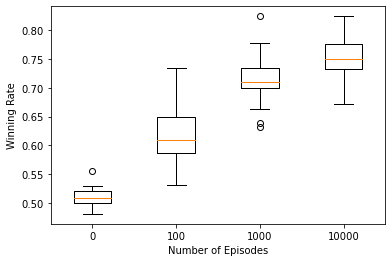

In [47]:
plt.boxplot([iteration[0], iteration[100], iteration[1000], iteration[10000]],labels=[0,100,1000,10000])
plt.xlabel('Number of Episodes')
plt.ylabel('Winning Rate')

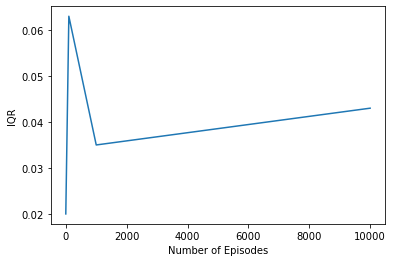

In [58]:
# iqr
y1 = [iqr(iteration[0]), iqr(iteration[100]),iqr(iteration[1000]),iqr(iteration[10000])]

x = [0, 100, 1000, 10000]


plt.plot(x, y1)
plt.xlabel('Number of Episodes')
plt.ylabel('IQR')
plt.show()

In [43]:
# expected short fall
import scipy
def es(array):
    array = np.asarray(array)
    value_at_risk = scipy.stats.scoreatpercentile(array, 100 * 0.05)
    cvar = array[array <= value_at_risk].mean()
    return cvar
y1 = [iqr(iteration[0]), iqr(iteration[100]),iqr(iteration[1000]),iqr(iteration[10000])]
y2 = [es(iteration[0]), es(iteration[100]),es(iteration[1000]),es(iteration[10000])]

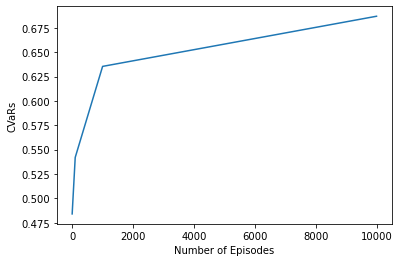

In [59]:
# iqr


y2 = [es(iteration[0]), es(iteration[100]),es(iteration[1000]),es(iteration[10000])]

x = [0, 100, 1000, 10000]


plt.plot(x, y2)
plt.xlabel('Number of Episodes')
plt.ylabel('CVaRs')
plt.show()




[Text(0.5, 0, 'Number of Episodes'), Text(0, 0.5, 'CVaRs')]

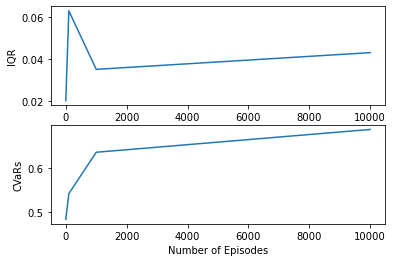

In [60]:
fig, axs = plt.subplots(2)
axs[0].plot(x, y1)
axs[1].plot(x, y2)
axs[0].set(xlabel='Number of Episodes', ylabel='IQR')
axs[1].set(xlabel='Number of Episodes', ylabel='CVaRs')

In [33]:
# expected short fall
import scipy
def es(array):
    array = np.asarray(array)
    value_at_risk = scipy.stats.scoreatpercentile(array, 100 * (1-0.05))
    cvar = array[array <= value_at_risk].mean()
    return cvar
es(iteration[0]), es(iteration[100]),es(iteration[1000]),es(iteration[10000])

(506.1304347826087, 610.3913043478261, 709.2173913043479, 750.9583333333334)

In [ ]:
value_at_risk = scipy.stats.scoreatpercentile(array, 100 * 0.05)
cvar = array[array <= value_at_risk].mean()

In [174]:
array = np.asarray(iteration[100])

# old

In [125]:
reward_td = 0
for i in range(1000): 
    td.env = gym.make('gym_go:go-v0', size=size,  reward_method = "real")
    td.env.reset()
    done = False

    while not done:
        states = all_state2num(td.env.state(),size)
        action_index = td.apply_policy(states, 0.1)
        state, reward, done, info = td.env.step(action_index)
        if done:
            break
        # white    
        action = td.env.uniform_random_action()
        state, reward, done, info = td.env.step(action)
    if reward == 1:
        reward_td += 1

### Save policy

In [41]:
# save policy
#dict_data = td.action_function
#a_file = open("data.pkl", "wb")
#pickle.dump(dict_data, a_file)
#a_file.close()
size = 3
td = Learn(size = size)
a_file = open("data.pkl", "rb")
output = pickle.load(a_file)

a_file.close()
td.load_policy(output)

## reward & Value Function

In [47]:
# after traning 
rewards_td = [0]*25
#value_td = [0]*25
states_start = [0]*25
states_end = [0]*25
states_inter = [0]*25
for j in range(25):
    print(j)
    reward_td = []
    start = []
    end = []
    inter  = []

    for i in range(1000): 
        td.env = gym.make('gym_go:go-v0', size=size,  reward_method = "real")

        done = False

        states = all_state2num(td.env.state(),size)
        #state = a.env.state()[0:2].reshape(size**2*2)
        action_index = td.apply_policy(states, 0.1)
        #action = go_env.uniform_random_action()
        state, reward, done, info = td.env.step(action_index)

        idx, s, f = symmetry_action(all_state2num(td.env.state(), size), td.action_function, 0, size)

        start.append(s)
        reward_td.append(reward)

        while not done:
             # white    
            action = td.env.uniform_random_action()
            state, reward, done, info = td.env.step(action)

            if done:
                break


            states = all_state2num(td.env.state(),size)

            #state = a.env.state()[0:2].reshape(size**2*2)
            action_index = td.apply_policy(states, 0.1)
            #action = go_env.uniform_random_action()
            state, reward, done, info = td.env.step(action_index)
            #print(reward)
            [action_idx, state, flag] = symmetry_action(states, td.action_function, action_index, size)
            
            # state 
            inter.append(state)
                
            # reward
            if not done:
                reward_td.append(reward)


        idx, s, f = symmetry_action(states, td.action_function, 0, size) 
        
        end.append(s)
        
    states_start[j] = start
    states_end[j] = end
    states_inter[j] = inter
    rewards_td[j]=reward_td
        
        
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


# Evaluation
## reward

In [370]:
# increace winning rate by ~25%
rewards.count(1.0),rewards.count(0),rewards.count(-1)

(837, 47, 116)

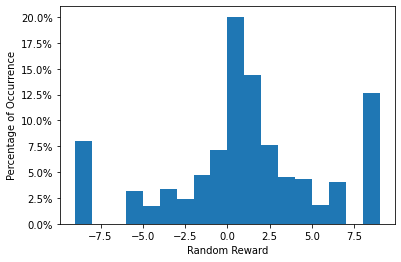

[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]


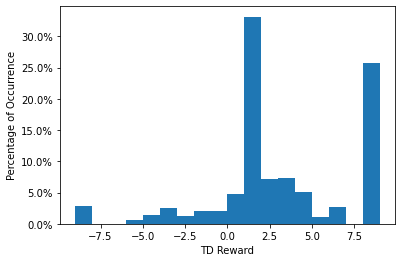

[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]


In [21]:
# Random
from matplotlib.ticker import PercentFormatter
#np.save('rewards_inter_non.npy', rewards_inter_non)
rewards_inter_non = np.load('rewards_inter_non.npy', allow_pickle=True)
plt.hist(rewards_inter_non[1], weights=np.ones(len(rewards_inter_non[1])) / len(rewards_inter_non[1]), bins = 18)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('Random Reward')
plt.show()
non_iqr = []
for i in rewards_inter_non:
    non_iqr.append(iqr(i))
print(non_iqr)
#plt.boxplot(non_iqr)

# TD
#np.save('rewards_td.npy', rewards_td)
rewards_td = np.load('rewards_td.npy', allow_pickle=True)
plt.hist(rewards_td[1], weights=np.ones(len(rewards_td[1])) / len(rewards_td[1]), bins = 18)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('TD Reward')

plt.show()
td_iqr = []
for i in rewards_td:
    td_iqr.append(iqr(i))
#plt.boxplot(td_iqr)
print(td_iqr)

## Value Function

In [63]:
start_values = []
for i in states_start:
    start_value = []
    for j in i:
        if j not in td.action_function:
            start_value.append(0)
        else:
            start_value.append(np.sum(td.action_function[j]))
    start_values.append(start_value)
    
end_values = []
for i in states_end:
    end_value = []
    for j in i:
        if j not in td.action_function:
            end_value.append(0)
        else:
            end_value.append(np.sum(td.action_function[j]))
    end_values.append(end_value)
    
inter_values = []
for i in states_inter:
    inter_value = []
    for j in i:
        if j not in td.action_function:
            inter_value.append(0)
        else:
            inter_value.append(np.sum(td.action_function[j]))
    inter_values.append(inter_value)
    
all_values = []
for i in range(25):
    all_value = []
    all_value.extend(start_values[i])
    all_value.extend(end_values[i])
    all_value.extend(inter_values[i])
    all_values.append(all_value)
#ax = sns.distplot(ls, bins=20, kde=False)
#plt.ylabel('No. Occurance')
#plt.xlabel('State Value (Starting States)')
#plt.show()

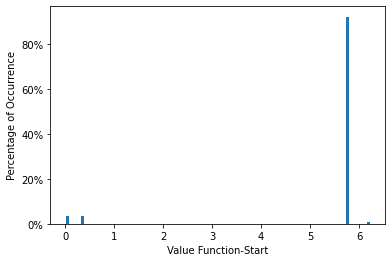

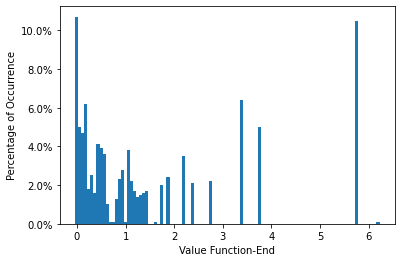

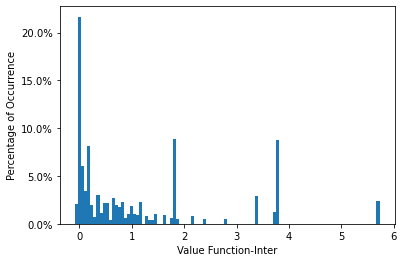

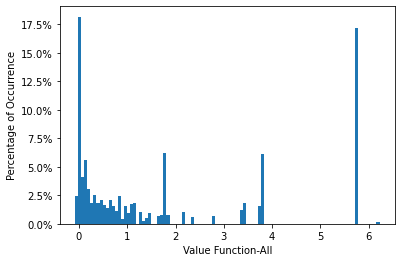

In [70]:
#np.save('start_values.npy', start_values)
#np.save('end_values.npy', end_values)
#np.save('inter_values.npy', inter_values)
#np.save('all_values.npy', all_values)

#start_values = np.load('start_values.npy', allow_pickle=True)
#end_values = np.load('end_values.npy', allow_pickle=True)
#inter_values = np.load('inter_values.npy', allow_pickle=True)
#all_values = np.load('all_values.npy', allow_pickle=True)

plt.hist(start_values[1], weights=np.ones(len(start_values[1])) / len(start_values[1]), bins = 100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('Value Function-Start')
plt.show()

plt.hist(end_values[1], weights=np.ones(len(end_values[1])) / len(end_values[1]), bins = 100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('Value Function-End')
plt.show()

plt.hist(inter_values[1], weights=np.ones(len(inter_values[1])) / len(inter_values[1]), bins = 100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('Value Function-Inter')
plt.show()

plt.hist(all_values[1], weights=np.ones(len(all_values[1])) / len(all_values[1]), bins = 100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('Value Function-All')
plt.show()



Text(0.5, 0, 'States')

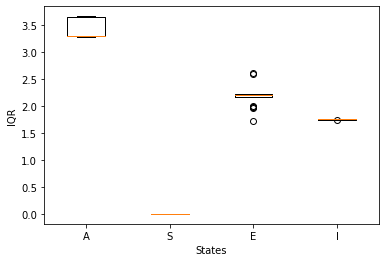

In [82]:
all_iqr_value = []
start_iqr_value = []
end_iqr_value = []
inter_iqr_value = []
for i in range(25):
    all_iqr_value.append(iqr(all_values[i]))
    start_iqr_value.append(iqr(start_values[i]))
    end_iqr_value.append(iqr(end_values[i]))
    inter_iqr_value.append(iqr(inter_values[i]))
plt.boxplot([all_iqr_value,start_iqr_value, end_iqr_value, inter_iqr_value], 
            labels=list('ASEI'))
plt.ylabel('IQR')
plt.xlabel('States')